Linear Method

## Commentaires et communication entre nous:

J'ai changé l'évalution des erreurs, j'avais calculé des MSE en général, mais sur kaggle on sera évalués sur la RMSE, ça change presque rien mais comme ça c'est pareil. Parfait, merci

In [29]:
data <- read.csv(file.path("..", "data", "training_data.csv"))
data<-data[,-which(names(data) %in% c("SWEETORSOUR"))] #to remove the SWEETORSOUR response variable
data$Intensity<-as.numeric(as.factor(data$Intensity)) #more efficient, this way we only have one column with 2=high, 1=low
#data<-data[ , which(apply(data, 2, var) != 0)] #remove all columns with variance=0
data

Intensity,VALENCE.PLEASANTNESS,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,...,Depressant.80,Depressant.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
2,45,302.0,208.33,5.952,19.698,34.491,21.523,39.571,0.563,...,0,0,1,0,1,0,1,0,1,0
1,49,72.6,122.18,6.431,11.349,18.745,12.261,21.285,0.597,...,0,0,0,0,0,0,0,0,0,0
1,56,259.0,242.29,7.572,20.832,32.167,21.693,35.535,0.651,...,1,0,1,0,1,1,1,0,1,1
1,7,56.6,88.12,6.294,7.537,14.189,7.955,16.080,0.538,...,0,0,0,0,0,0,0,0,0,0
2,51,84.7,136.21,6.191,12.876,21.629,14.023,24.701,0.585,...,0,0,0,0,0,0,0,0,0,0
1,21,160.0,192.28,6.409,17.644,29.723,19.000,33.740,0.588,...,0,0,0,0,1,0,1,0,1,0
2,56,116.0,170.22,7.401,15.349,22.745,16.261,25.285,0.667,...,0,0,0,0,1,0,0,0,1,0
2,52,25.0,114.26,4.395,12.741,24.952,14.853,29.737,0.490,...,0,0,0,0,0,0,0,0,0,0
2,53,355.0,268.30,7.666,21.304,36.025,21.614,39.950,0.609,...,1,0,1,0,1,1,1,1,1,1
2,1,68.4,152.26,9.516,9.911,16.342,11.250,17.920,0.619,...,0,0,0,0,0,0,0,0,0,0


In [30]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

In [31]:
#Linear regression on the data set with the test and training errors

set.seed(199)
#idx.train <- sample(nrow(data), nrow(data)/2)
#data.train <- data[idx.train,]
#data.test <- data[-idx.train,]

lm.fit <- lm(VALENCE.PLEASANTNESS ~ ., data.train)
summary(lm.fit)
RSS = sum((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2)
RSS
RMSE=sqrt(mean((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2))
print(RMSE)
#quality.of.fit <- function(fit, data) {
#    RSS <- sum((data$VALENCE.PLEASANTNESS - predict(fit, data))^2)
#    TSS <- sum((data$VALENCE.PLEASANTNESS - mean(data$VALENCE.PLEASANTNESS))^2)
#    cat(c("Residual standard error: ", sqrt(1/(nrow(data) - length(coefficients(fit))) * RSS), " R^2 = ", 1 - RSS/TSS, "\n")) }
#quality.of.fit(lm.fit, data.train)
#quality.of.fit(lm.fit, data.test)

#--> test RSS very high
#-->RMSE is 62719 as a baseline for comparison #but potentially some error


Call:
lm(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.022  -1.907   0.000   1.522  46.652 

Coefficients: (2776 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)  
(Intercept)             1.119e+08  6.241e+07   1.793   0.0760 .
Intensity               2.044e+00  2.907e+00   0.703   0.4835  
complexity.from.pubmed -8.953e+01  4.345e+01  -2.061   0.0419 *
MW                     -2.843e+04  1.665e+04  -1.707   0.0908 .
AMW                    -4.267e+05  2.333e+05  -1.829   0.0703 .
Sv                      7.638e+06  4.219e+06   1.810   0.0732 .
Se                      7.733e+06  4.225e+06   1.831   0.0701 .
Sp                     -1.929e+06  1.056e+06  -1.827   0.0707 .
Si                      3.347e+06  1.865e+06   1.795   0.0756 .
Mv                      1.060e+07  5.811e+06   1.824   0.0712 .
Me                      3.446e+05  1.509e+05   2.284   0.0245 *
Mp            

Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] 1.392539e+12

Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] 62719.42


Warning message:
"package 'leaps' was built under R version 3.6.3"Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2696  linear dependencies found"

Reordering variables and trying again:


[1] 0.05065697 0.07593395 0.10008965 0.12229407 0.13745606 0.15286374
 [7] 0.16742750 0.17947292 0.19129647 0.20017931 0.20918474 0.21832711
[13] 0.22607490 0.23673659 0.24404007 0.25151833 0.25609372 0.26116071
[19] 0.26711840 0.27302513 0.27868506 0.28425794 0.28967247 0.29672898
[25] 0.30514687 0.31304735 0.32084717 0.32634856 0.33197169 0.33706500
[31] 0.34086459 0.34443221 0.34822336 0.35137525 0.35506787 0.35851680
[37] 0.36109893 0.36392312 0.36801148 0.37216922 0.37708112

ERROR: Error in xy.coords(x, y): objet 'regfit.fwd.summary' introuvable


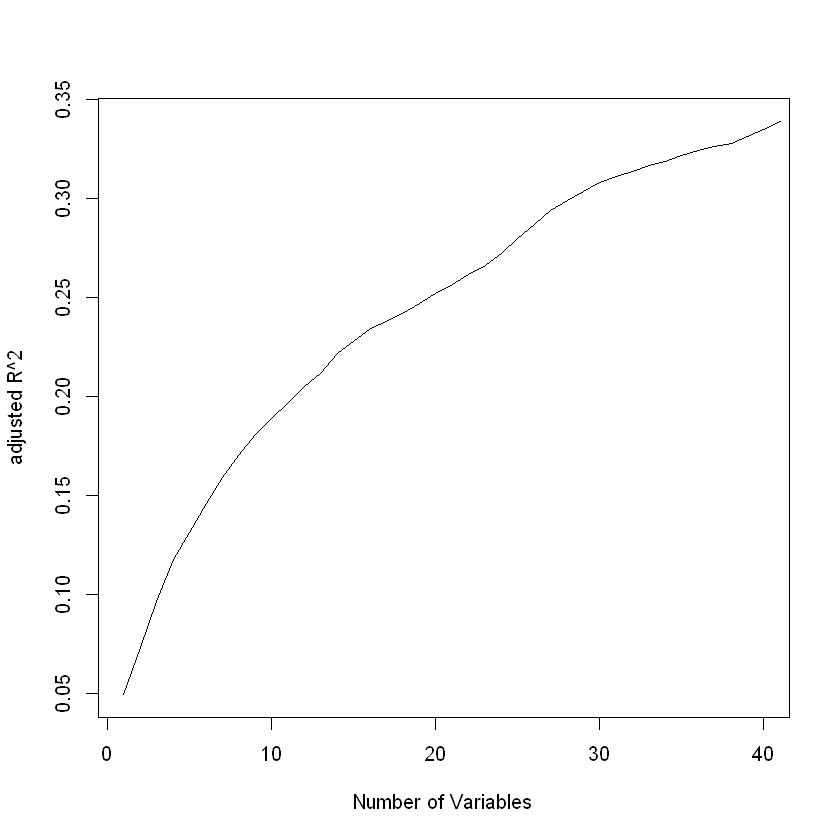

In [32]:
#Foreward selection without cross validation

library(leaps)
nvmax = 40 # Which nmax ? with 40 ~10min to run
reg.fit <- regsubsets(VALENCE.PLEASANTNESS~., data, really.big = T, method = 'forward', nvmax = nvmax) 
regfit.summary <- summary(reg.fit)
summary(reg.fit)$rsq

plot(regfit.summary$adjr2, type = "l", xlim = c(1,nvmax), xlab = "Number of Variables", ylab = "adjusted R^2")
adjr2.max <- which.max(regfit.summary$adjr2)
points(adjr2.max, regfit.fwd.summary$adjr2[adjr2.max], col = "red", cex = 2, pch = 20)

#--> The adjusted R^2 increase with the nb of variables
#--> But : R^2 adjusted is not appropriate in high dimensions : R^2 adjusted = 1 if RSS = 0
#--> Better to mix forward selection with cross validation

In [36]:
#Cross-validation with on each fold foreward selection

#install.packages('tidymodels')
library(leaps)
library(tidymodels)

predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}
           
validation_data <- vfold_cv(data, v = 5)
fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 30)
    evaluate(fold, fit)
}
           
cv.errors <- sapply(validation_data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)
           
#Long à compiler genre env 20-30min
#peut etre à essayer avec d'autre v ou nvmax

Warning message:
"package 'tidymodels' was built under R version 3.6.3"

ERROR: Error: package or namespace load failed for 'tidymodels' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace 'magrittr' 1.5 is already loaded, but >= 2.0.0 is required


In [37]:
cv.errors
mean.cv.errors           
plot(mean.cv.errors, type = "l", ylim = c(1, 500), xlab = "Number of Variables", ylab = "5-fold CV right")
cv.min = which.min(mean.cv.errors)
cv.min #11
mean.cv.errors[cv.min] #297.123
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(data$Y), 0, lty = "dashed")

print(paste0('RMSE cv min : ', sqrt(mean.cv.errors[cv.min])))
#--> The errors are very high around 300 : the min error = 297 with cv min =11
#--> I think with a higher nvmax it should give a better error but it will take higher amount of time to run 

ERROR: Error in eval(expr, envir, enclos): objet 'cv.errors' introuvable


In [38]:
#data1 <- as.matrix(data_prepared) #--> Je n'arrive pas à changer les data en matrice pour pouvoir utiliser la regularization ??

    #-->Je ne sais pas si c'est la meilleure solution mais glmnet ne gère apparement pas les variables en catégories, il faut donc les remplacer par des dummy variables
    
#filtre sur les données numériques pour ne pas prendre les columnes avec variance 0 et ne pas prendre la réponse, rend le calcul compliqué je ne sais pas si c'est nécessaire
#cols = names(data.dummy[, sapply(data.dummy, function(v) var(v) != 0)]) #eliminate columns woth zero variance

##--> mieux de faire sur data.train? 
#prepare dummy variables
data1x<-data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
#levels(data1x$Intensity) <- c(1,0) #more efficient, this way we only have one column with 1=high, 0=low
#data1x<-as.matrix(data1x)
#data1x
data1x <- model.matrix(~.-1, data1x)#creates dummy variables
data1y<-data.train$VALENCE.PLEASANTNESS


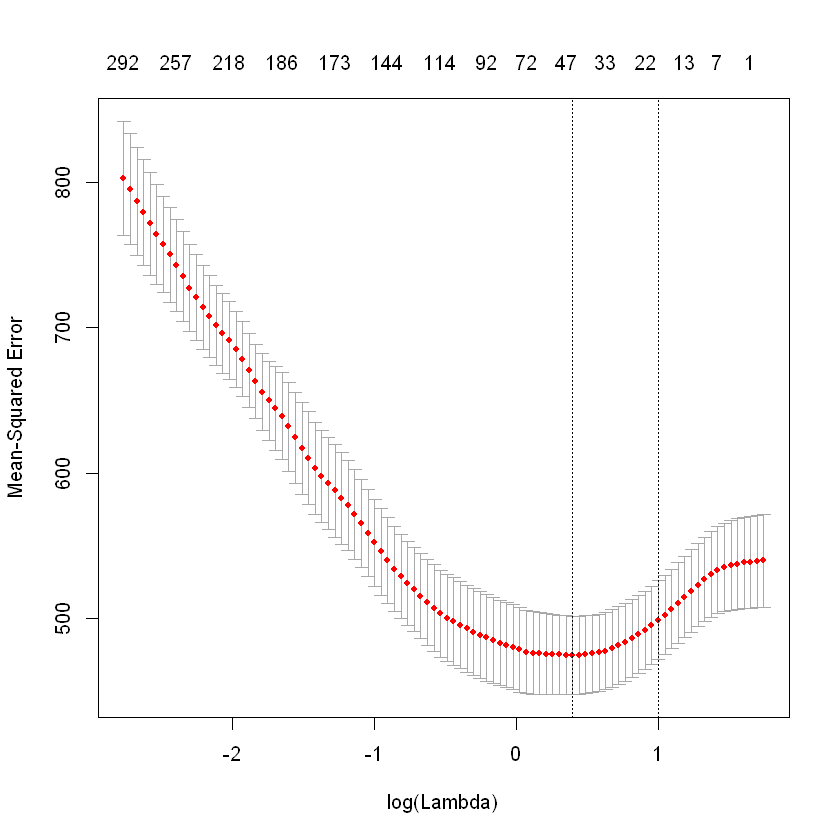

In [39]:
#Cross-validation Lasso
set.seed(12)
#install.packages('glmnet')
library(glmnet)

#cross-validation lasso on training set
cv.lasso <- cv.glmnet(data1x, data1y, alpha = 1)
plot(cv.lasso)
best.lasso <- glmnet(data1x, data1y, alpha = 1, lambda = cv.lasso$lambda.min)
coeffs<-coef(best.lasso)
#best number of predictors is always changing if the seed is not set??

In [40]:
y<-predict(best.lasso,data1x)
RMSE.train=sqrt(mean((y-data1y)**2))
RMSE.train

[1] 19.30019

In [41]:
#prepare test data

data1x.test<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data1x.test<- model.matrix(~.-1, data1x.test)
data1y.test<-data.test$VALENCE.PLEASANTNESS

#test lasso regularization on test set
y<-predict(best.lasso, data1x.test)
RMSE.test=sqrt(mean((y-data1y.test)**2))

RMSE.test
#still quite high test error

[1] 22.57012

[1] "RMSE for training set: 18.7726252859476"
[1] "RMSE for test set: 22.5009722975498"


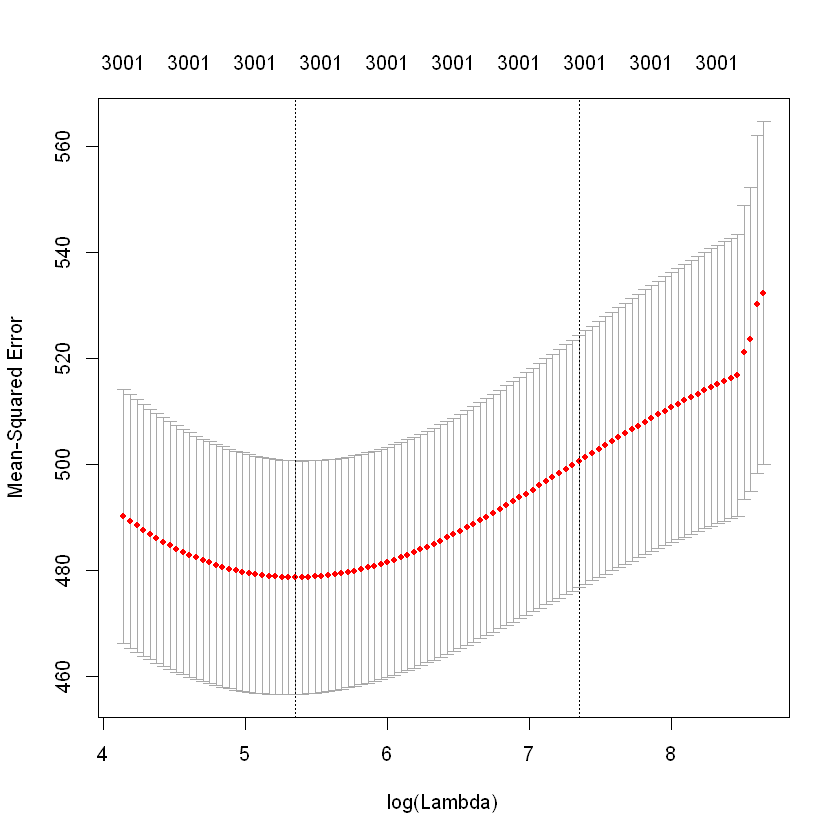

In [42]:
#Same process using Ridge regularization
set.seed(12)

#cross-validation ridge on training set
cv.ridge <- cv.glmnet(data1x, data1y, alpha = 0)
plot(cv.ridge)
best.ridge <- glmnet(data1x, data1y, alpha = 0, lambda = cv.ridge$lambda.min)
coeffs<-coef(best.ridge)

#use model on training data set
y<-predict(best.ridge,data1x)
RMSE.train=sqrt(mean((y-data1y)**2))
print(paste0("RMSE for training set: ",RMSE.train))

#test ridge regularization on test set
y<-predict(best.ridge, data1x.test)
RMSE.test=sqrt(mean((y-data1y.test)**2))

print(paste0("RMSE for test set: ",RMSE.test))

In [27]:
## The results are better with lasso regularization and we will choose lasso regularization with the bootstrap approach.

In [43]:
#The data might have confounder effect, we are going to try using bootstrap data sets

bootstrap<-function(data) data[sample(nrow(data),nrow(data),replace=T),]

fitted.coefficients.lasso <- function(data){
    #prepare data
    datax<-data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))]
    datax<- model.matrix(~.-1, datax)
    datay<-data$VALENCE.PLEASANTNESS

    cv.lasso <- cv.glmnet(datax, datay, alpha = 1)
    best.lasso <- glmnet(datax, datay, alpha = 1, lambda = cv.lasso$lambda.min)
    return(coef(best.lasso))
}

#not functionning
summarize <- function(coeffs) {
    m <- Matrix::rowMeans(coeffs)
    B <- ncol(coeffs)
    data.frame(Estimate = m, Std.Error = sqrt(1/(B-1)*rowSums((coeffs - m)^2)))
}
#number of bootstrap data.sets
B=3
#summarize( #je n'ai pas encore réussi à faire une fonction correcte pour summarize..
m<-replicate(B,fitted.coefficients.lasso(bootstrap(data.train)))

In [44]:
beta<-rowMeans(m[[1]][],m[[2]][],m[[3]][]) #permet de visualiser les résultats pour le bootstrap, il faudrait trouver une fonction pour les calculer

bias_input <- function(X) cbind(rep(1, ifelse(is.null(nrow(X)), length(X), nrow(X))), X)

#check before matrix mutliplication
#length(beta) print if you need
#preparation of train set to fit output form
data.train.prep<-bias_input(model.matrix(~.-1, data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))])) #add column of 1 for the intercept


#compute train error
y.pred<-data.train.prep%*%beta
RMSE_bootstrap.train<-sqrt(mean((y.pred-data.train$VALENCE.PLEASANTNESS)**2))
print(paste0("RMSE on the training data with bootstrap: ",RMSE_bootstrap.train))

#compute test error
data.test.prep<-bias_input(model.matrix(~.-1, data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))])) #add column of 1 for the intercept
y.test.pred<-data.test.prep%*%beta
RMSE_bootstrap.train<-sqrt(mean((y.test.pred-data.test$VALENCE.PLEASANTNESS)**2))
print(paste0("RMSE on the test data with lasso regularization and bootstrap: ",RMSE_bootstrap.train))

#résultats légèrement meilleurs que sans bootstrap sur le train set mais pas le test set

[1] "RMSE on the training data with bootstrap: 18.7821816818713"
[1] "RMSE on the test data with lasso regularization and bootstrap: 26.2978608919408"


In [ ]:
#Test with gradient descent (je te laisse mes data préparées si ça t'es utile)

In [4]:
data.train.y<-data.train$VALENCE.PLEASANTNESS
data.train.x<-data.train[,-(which(names(data.train) %in% c("VALENCE.PLEASANTNESS")))]
data.train.x<- as.matrix((model.matrix(~.-1, data.train.x))) #impossible de faire la mulitplication matricielle sinon

#data.test
data.test.x<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data.test.x<- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y<-data.test$VALENCE.PLEASANTNESS


In [16]:
#library(ADtools) can not be installed easily locally on windows, essai avec un algorithm trouvé sur kaggle
#install.packages('ADtools')
library('ADtools')
gradient_descent <- function(f, params, fix = list(),
                             learning_rate = 0.01,
                             tol = 1e-6,
                             maxsteps = 10^3,
                             show = F) {
  history <- rep(0, maxsteps)
  for (i in 1:maxsteps) {
    df <- auto_diff(f, at = append(params, fix), wrt = names(params))
    if (show) print(df@x)
    history[i] <- df@x
    delta <- learning_rate * as.numeric(df@dx)
    params <- relist(unlist(params) - delta, params)
    print(delta)
    if (max(abs(delta)) < tol) break #cette ligne ne fait compiler le result du bas ???
  }
  append(params, list(history = history))
}

params <- lm.fit$coefficients
params[is.na(params)] <- 0 #replace the NA betas by 0


lm_loss <- function(params, X, Y) mean((Y - X %*% params)^2)
lm_loss(params, data.train.x, data.train.y)
lm_loss(params, data.test.x, data.test.y)

#--> loss function very big ??? 
#Ce n'est pas normal ?? ou oui

[1] 6.129838e+15

[1] 6.199601e+15

In [17]:
#With training set
result.train <- gradient_descent(f = lm_loss, learning_rate = 1e-1,
                            maxsteps = 500,
                            params = list(params = params),
                            fix = list(X = data.train.x, Y = data.train.y))
#ne compile pas si il y a la ligne : if (max(abs(delta)) < tol) dans la fonction gradient descent
#si on enleve compile mais resultats très bizarre
#j'ai l'impression que gradient descent n'arrive pas a mettre une valeur dans delta ??
plot(result.train$history, ylab = "training loss", xlab = "iteration")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ERROR: Error in if (max(abs(delta)) < tol) break: valeur manquante là où TRUE / FALSE est requis


In [18]:
#With test set
result.test <- gradient_descent(f = lm_loss, learning_rate = 1e-1,
                            maxsteps = 500,
                            params = list(params = params),
                            fix = list(X = data.test.x, Y = data.test.y))
plot(result.test$history, ylab = "test loss", xlab = "iteration")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ERROR: Error in if (max(abs(delta)) < tol) break: valeur manquante là où TRUE / FALSE est requis


In [19]:
#Regularization with gradient descent
regularized_loss <- function(loss, lambda0 = 0, lambda1 = 0) {
    function(params, X, Y) {
        loss(params, X, Y) + lambda0 * sum(sqrt(params^2)) + lambda1 * sum(params^2)
    }
}


result.train.lasso <- gradient_descent(regularized_loss(lm_loss, lambda1 = 5),
                           learning_rate = 1e-4,
                           params = list(params = params),
                           fix = list(X = data.train.x, Y = data.train.y))
result.train$params

result.test.lasso <- gradient_descent(regularized_loss(lm_loss, lambda1 = 5),
                           learning_rate = 1e-4,
                           params = list(params = params),
                           fix = list(X = data.test.x, Y = data.test.y))
result.test$params


   [1] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
  [19] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
  [37] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
  [55] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
  [73] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
  [91] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [109] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [127] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [145] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [163] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [181] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [199] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
 [217] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN N

ERROR: Error in if (max(abs(delta)) < tol) break: valeur manquante là où TRUE / FALSE est requis
